# Generate blood vessels with random bezier curves

In [9]:
import matplotlib.pyplot as plt
from vessel_geometry import VesselGeometry
import numpy as np
import torch

In [3]:
size = 256 
# Set a random seed for reproducibility
np.random.seed(42)

# Define the ranges for the parameters
size = 256
n_control_points_range = (2, 15)    # "complexity" of the curves
max_vd_range = (50.0, 150.0)        # Sets the typical curvature of the curves
radius_range = (1, 4)               # Radius of each curve
num_curves_range = (1, 15)          # Number of curves to generate

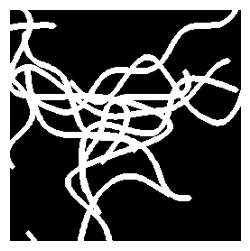

In [4]:
n_control_points = np.random.randint(*n_control_points_range)
max_vd = np.random.uniform(*max_vd_range)
radius = np.random.randint(*radius_range)
num_curves = np.random.randint(*num_curves_range)

vg = VesselGeometry(size, n_control_points, max_vd, radius, num_curves)
img = vg.create_curves()

plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


# Vessel Shape With texture

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Define the ranges for the parameters
size = 256
n_control_points_range = (2, 15)    # "complexity" of the curves
max_vd_range = (50.0, 150.0)        # Sets the typical curvature of the curves
radius_range = (1, 4)               # Radius of each curve
num_curves_range = (1, 15)          # Number of curves to generate

n_control_points = np.random.randint(*n_control_points_range)
max_vd = np.random.uniform(*max_vd_range)
radius = np.random.randint(*radius_range)
num_curves = np.random.randint(*num_curves_range)

In [6]:
from vessel_shape import VesselShape

# Parameters for the dataset
texture_dir = 'imagenet_val_sample'  # Update as needed
annotation_csv = 'imagenet_val_sample/ILSVRC2012_img_val_annotation.csv'

dataset = VesselShape(
    image_size=256,
    n_control_points=5,
    max_vd=80,
    radius=2,
    num_curves=3,
    texture_dir=texture_dir,
    annotation_csv=annotation_csv,
    crop_size=(256, 256),
    n_samples=5
)


Dataset length: 5


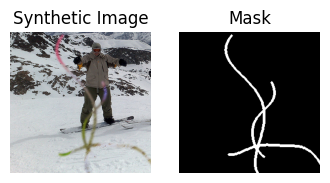

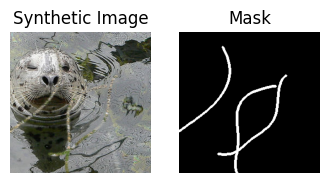

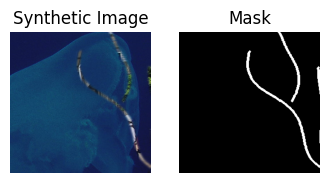

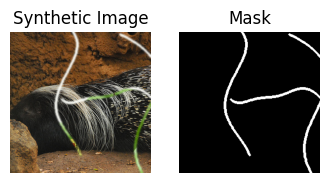

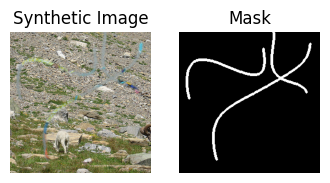

In [7]:
print(f"Dataset length: {len(dataset)}")

for idx in range(len(dataset)):
    img, mask = dataset[idx]
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Synthetic Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

## Testando geração de batches em runtime com DataLoader do PyTorch

Batch imgs shape: torch.Size([3, 3, 256, 256])
Batch masks shape: torch.Size([3, 1, 256, 256])


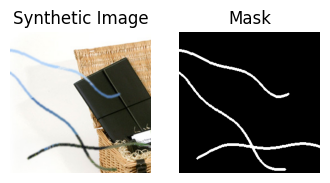

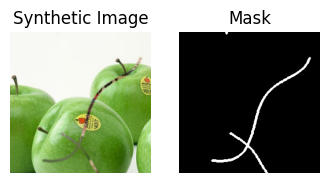

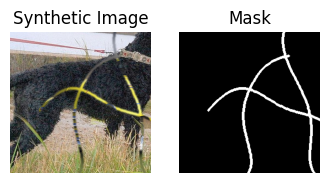

In [18]:
import torch
from torch.utils.data import DataLoader
from vessel_shape import VesselShape

# Instanciando o dataset para geração em runtime
ds_runtime = VesselShape(
    image_size=256,
    n_control_points=5,
    max_vd=80,
    radius=2,
    num_curves=3,
    texture_dir=texture_dir,
    annotation_csv=annotation_csv,
    crop_size=(256, 256),
    n_samples=8,  # total de imagens por época
)

class VesselShapeTorchDataset(torch.utils.data.Dataset):
    def __init__(self, vessel_shape_dataset):
        self.ds = vessel_shape_dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, mask = self.ds[idx]
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
        return img, mask

# Dataset PyTorch
torch_dataset = VesselShapeTorchDataset(ds_runtime)

# DataLoader para gerar batches
dataloader = DataLoader(torch_dataset, batch_size=3, shuffle=True)

# Resetando a época antes de começar (importante para datasets runtime)
ds_runtime.reset_epoch()

for batch_imgs, batch_masks in dataloader:
    print('Batch imgs shape:', batch_imgs.shape)  # [B, C, H, W]
    print('Batch masks shape:', batch_masks.shape)  # [B, 1, H, W]
    # Visualizando o primeiro batch
    for i in range(batch_imgs.shape[0]):
        img_np = (batch_imgs[i].permute(1,2,0).numpy() * 255).astype('uint8')
        mask_np = (batch_masks[i][0].numpy() * 255).astype('uint8')
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1)
        plt.imshow(img_np)
        plt.title('Synthetic Image')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.show()
    break  # Apenas um batch para teste

## Definindo uma UNet pequena para segmentação

In [10]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.final = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        return self.final(dec1)

# Instanciando o modelo (sem pesos pré-treinados)
model = UNetSmall(in_channels=3, out_channels=1)
print(model)

UNetSmall(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(in

## Treinando a UNet pequena com o dataset sintético gerado em runtime e plotando curvas

Epoch 1/10


Treino Época 1: 100%|██████████| 16/16 [00:19<00:00,  1.25s/it]


Train loss: 0.3332 | Train IoU: 0.6280


Validação Época 1: 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Valid loss: 0.0670 | Valid IoU: 1.0000
Epoch 2/10


Treino Época 2: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Train loss: 0.0237 | Train IoU: 1.0000


Validação Época 2: 100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Valid loss: 0.0038 | Valid IoU: 1.0000
Epoch 3/10


Treino Época 3: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Train loss: 0.0027 | Train IoU: 1.0000


Validação Época 3: 100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


Valid loss: 0.0023 | Valid IoU: 1.0000
Epoch 4/10


Treino Época 4: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


Train loss: 0.0021 | Train IoU: 1.0000


Validação Época 4: 100%|██████████| 4/4 [00:00<00:00, 14.01it/s]


Valid loss: 0.0018 | Valid IoU: 1.0000
Epoch 5/10


Treino Época 5: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


Train loss: 0.0016 | Train IoU: 1.0000


Validação Época 5: 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Valid loss: 0.0016 | Valid IoU: 1.0000
Epoch 6/10


Treino Época 6: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


Train loss: 0.0016 | Train IoU: 1.0000


Validação Época 6: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s]


Valid loss: 0.0016 | Valid IoU: 1.0000
Epoch 7/10


Treino Época 7: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Train loss: 0.0016 | Train IoU: 1.0000


Validação Época 7: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]


Valid loss: 0.0016 | Valid IoU: 1.0000
Epoch 8/10


Treino Época 8: 100%|██████████| 16/16 [00:20<00:00,  1.25s/it]


Train loss: 0.0015 | Train IoU: 1.0000


Validação Época 8: 100%|██████████| 4/4 [00:00<00:00, 14.23it/s]


Valid loss: 0.0016 | Valid IoU: 1.0000
Epoch 9/10


Treino Época 9: 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


Train loss: 0.0016 | Train IoU: 1.0000


Validação Época 9: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]


Valid loss: 0.0015 | Valid IoU: 1.0000
Epoch 10/10


Treino Época 10: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Train loss: 0.0015 | Train IoU: 1.0000


Validação Época 10: 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]


Valid loss: 0.0016 | Valid IoU: 1.0000


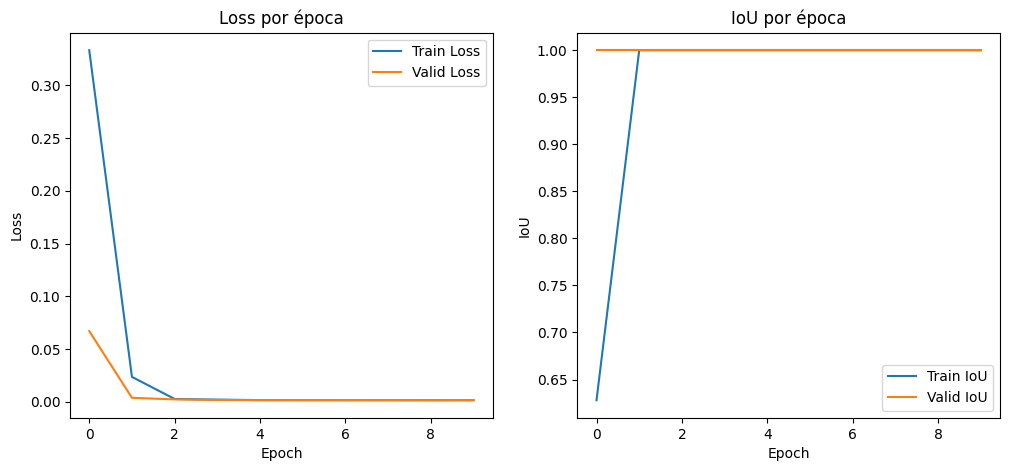

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader

# Instanciando datasets para treino e validação
ds_train = VesselShape(
    image_size=256, n_control_points=5, max_vd=80, radius=2, num_curves=3,
    texture_dir=texture_dir, annotation_csv=annotation_csv, crop_size=(256, 256), n_samples=1000
)
ds_valid = VesselShape(
    image_size=256, n_control_points=5, max_vd=80, radius=2, num_curves=3,
    texture_dir=texture_dir, annotation_csv=annotation_csv, crop_size=(256, 256), n_samples=16
)

class VesselShapeTorchDataset(torch.utils.data.Dataset):
    def __init__(self, vessel_shape_dataset):
        self.ds = vessel_shape_dataset
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        img, mask = self.ds[idx]
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
        return img, mask

train_dataset = VesselShapeTorchDataset(ds_train)
valid_dataset = VesselShapeTorchDataset(ds_valid)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

# Função de loss e otimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetSmall(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

def batch_iou(preds, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(preds) > threshold).float()
    targets = (targets > 0.5).float()
    intersection = (preds * targets).sum(dim=[1,2,3])
    union = ((preds + targets) > 0).float().sum(dim=[1,2,3])
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()
    ds_train.reset_epoch()
    train_loss = 0.0
    train_iou = 0.0
    for imgs, masks in tqdm(train_loader, desc=f'Treino Época {epoch+1}'):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_iou += batch_iou(outputs, masks) * imgs.size(0)
    train_loss /= len(train_loader.dataset)
    train_iou /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_iou)
    print(f'Train loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}')

    model.eval()
    ds_valid.reset_epoch()
    valid_loss = 0.0
    valid_iou = 0.0
    for imgs, masks in tqdm(valid_loader, desc=f'Validação Época {epoch+1}'):
        imgs, masks = imgs.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            valid_loss += loss.item() * imgs.size(0)
            valid_iou += batch_iou(outputs, masks) * imgs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_iou /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_iou)
    print(f'Valid loss: {valid_loss:.4f} | Valid IoU: {valid_iou:.4f}')

# Plotando curvas de loss e IoU
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss por época')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train IoU')
plt.plot(valid_accs, label='Valid IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU por época')
plt.show()

## Testando o modelo treinado em novas imagens sintéticas

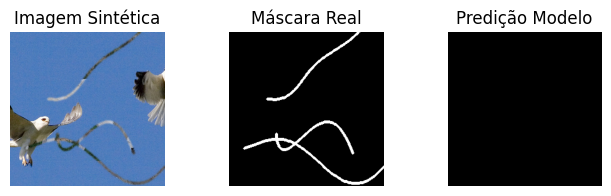

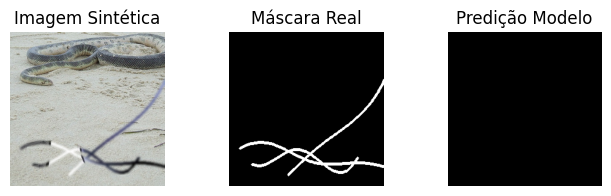

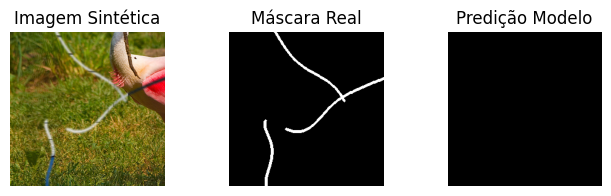

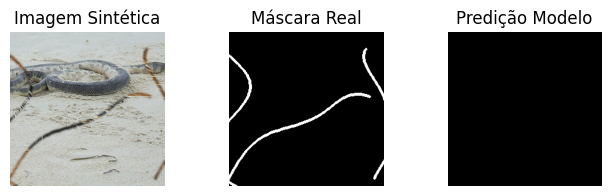

In [26]:
# Gerando novas imagens sintéticas para teste
ds_test = VesselShape(
    image_size=256, n_control_points=5, max_vd=80, radius=2, num_curves=3,
    texture_dir=texture_dir, annotation_csv=annotation_csv, crop_size=(256, 256), n_samples=4
)
test_dataset = VesselShapeTorchDataset(ds_test)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

ds_test.reset_epoch()
model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs) > 0.5
        for i in range(imgs.shape[0]):
            img_np = (imgs[i].cpu().permute(1,2,0).numpy() * 255).astype('uint8')
            mask_np = (masks[i][0].cpu().numpy() * 255).astype('uint8')
            pred_np = (preds[i][0].cpu().numpy() * 255).astype('uint8')
            plt.figure(figsize=(8,2))
            plt.subplot(1,3,1)
            plt.imshow(img_np)
            plt.title('Imagem Sintética')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.imshow(mask_np, cmap='gray')
            plt.title('Máscara Real')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(pred_np, cmap='gray')
            plt.title('Predição Modelo')
            plt.axis('off')
            plt.show()

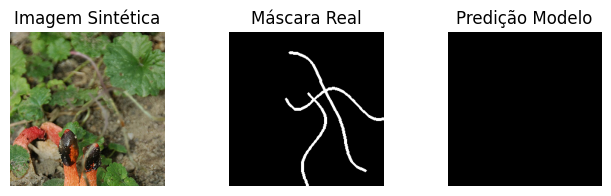

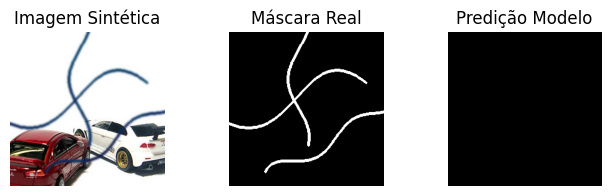

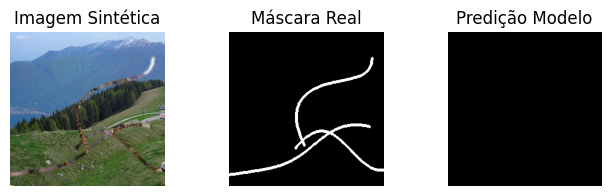

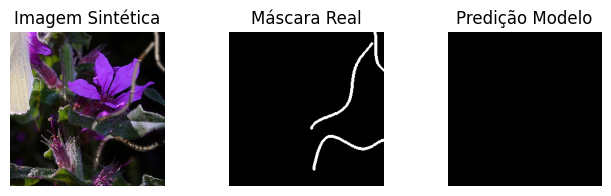

In [30]:
ds_test.reset_epoch()
model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs) > 0.5
        for i in range(imgs.shape[0]):
            img_np = (imgs[i].cpu().permute(1,2,0).numpy() * 255).astype('uint8')
            mask_np = (masks[i][0].cpu().numpy() * 255).astype('uint8')
            pred_np = (preds[i][0].cpu().numpy() * 255).astype('uint8')
            plt.figure(figsize=(8,2))
            plt.subplot(1,3,1)
            plt.imshow(img_np)
            plt.title('Imagem Sintética')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.imshow(mask_np, cmap='gray')
            plt.title('Máscara Real')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(pred_np, cmap='gray')
            plt.title('Predição Modelo')
            plt.axis('off')
            plt.show()